## Get thermochron data for cross-sections

Read in shapefile with a cross-section and a database with themrochronology data, select the datapoints within x km of the xsection and project these points on the xsection line. The results are saved as a csv file.

## Import modules

In [12]:
import math
import pandas as pd
import geopandas as gp
import shapely

import pyproj

## Filenames

In [13]:
xsection_file = '../data/xsections.shp'

# name of the cross-section to use
xsection_name = 'kuru_chu'

thermochron_data_file = '../data/thermochron_data.csv'

# maximum distance to cross-section (m)
max_distance = 15e3

## read xsection data

In [14]:
dg = gp.read_file(xsection_file)

In [15]:
dg

,id,name,reference,geometry
0,1,kuru_chu,mcquarrie2015,"LINESTRING (91.20377 26.78040, 91.20361 27.91714)"


## Select xsection

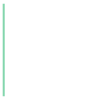

In [16]:
ind = dg['name'] == xsection_name

dgs = dg.loc[ind]

xsect = dgs.iloc[0].geometry

xsect

## Convert xsection coordinates to UTM

In [17]:
def find_utm_zone(lon, lat):

    """

    find the utm zone for lat/long coordinates

    :param lon:
    :param lat:
    :return:
    """

    zone = int(math.floor(((lon + 180.0) / 6)) + 1)

    bands = "CDEFGHJKLMNPQRSTUVWXX"

    band = bands[int(math.floor(((lat+80) / 8)))]

    return zone, band


utm_zone, utm_band = find_utm_zone(xsect.centroid.x, xsect.centroid.y)

# convert to utm
# debugging, set utm band to N for testing
#utm_band = ''
proj_text = "+proj=utm +zone=%i%s, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs" % (utm_zone, utm_band)
print('converting to local projection ', proj_text)
projection = pyproj.Proj(proj_text)

dgu = dgs.to_crs(proj_text)

converting to local projection  +proj=utm +zone=46R, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs


## Get UTM xsection

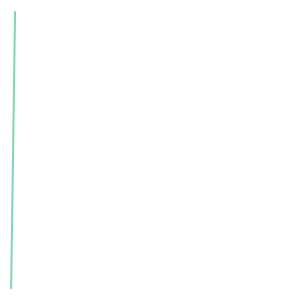

In [18]:
xsect_utm = dgu.iloc[0].geometry
xsect_utm

## Load thermochron data

In [22]:
dft = pd.read_csv(thermochron_data_file) #, X_POSSIBLE_NAMES="longitude", Y_POSSIBLE_NAMES="latitude")

In [24]:
# force numeric columns
cols = ['longitude', 'latitude']
dft[cols] = dft[cols].apply(pd.to_numeric, errors='coerce')

In [25]:
dft['geometry'] = dft.apply(lambda z: shapely.geometry.Point(z['longitude'], z['latitude']), axis=1)
dgt = gp.GeoDataFrame(dft)

In [26]:
dft['longitude']

0      91.480111
1      91.480278
2      91.547944
3      91.547611
4      91.530833
         ...    
741   -68.692600
742   -68.692600
743   -68.694400
744   -68.694400
745   -68.694400
Name: longitude, Length: 746, dtype: float64

In [27]:
dgt.geometry

0        POINT (91.48011 26.86572)
1        POINT (91.48028 26.87497)
2        POINT (91.54794 26.93311)
3        POINT (91.54761 26.95992)
4        POINT (91.53083 26.97442)
                  ...             
741    POINT (-68.69260 -21.83800)
742    POINT (-68.69260 -21.83800)
743    POINT (-68.69440 -21.83380)
744    POINT (-68.69440 -21.83380)
745    POINT (-68.69440 -21.83380)
Name: geometry, Length: 746, dtype: geometry

In [28]:
all_pts = shapely.geometry.MultiPoint(dgt.geometry.tolist())

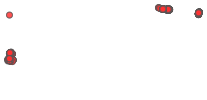

In [29]:
all_pts

## Convert the thermochronology data to utm

In [30]:
dgs.crs

{'init': 'epsg:4326'}

In [31]:
#dgt.set_crs(epsg=4326)
dgt.crs = dgs.crs
dgtu = dgt.to_crs(proj_text)

In [32]:
xsect_utm.coords[:]

[(321424.3909105797, 12963374.340129504),
 (323223.12119252526, 13089320.848438613)]

## Get distance to xsection for each point

In [33]:
for ix in dgtu.index:
    dgtu.loc[ix, 'distance_to_xsection'] = dgtu.loc[ix, 'geometry'].distance(xsect_utm)
    
dgtu['distance_to_xsection'].describe()

count     7.460000e+02
mean               inf
std                inf
min       8.895381e+01
25%       1.660967e+05
50%       3.073853e+06
75%       2.031504e+07
max      1.797693e+308
Name: distance_to_xsection, dtype: float64

## Get rid of pts that are more than x km away

In [34]:
close_enough = dgtu['distance_to_xsection'] < max_distance
dg2 = dgtu.loc[close_enough]

print('number of datapoints left = ', len(dg2))

number of datapoints left =  48


## Go through pts, project them onto xsection and get distance from xsection tip

In [35]:
for ix in dg2.index:
    dg2.loc[ix, 'projected_distance_along_xsection'] = xsect_utm.project(dg2.loc[ix, 'geometry'])

/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [36]:
dg2['projected_distance_along_xsection'].describe()

count        48.000000
mean      65662.124413
std       35440.342137
min       10818.116254
25%       41100.067846
50%       61477.944392
75%       90114.234189
max      125959.352118
Name: projected_distance_along_xsection, dtype: float64

## Save new csv file with projected distances along xsection

In [37]:
fn_out = thermochron_data_file[:-4] + '_projected.csv'

print('saving updated csv file with proijected distances along cross-section as %s' % fn_out)
dg2.to_csv(fn_out)

saving updated csv file with proijected distances along cross-section as ../data/thermochron_data_projected.csv


In [45]:
dg2['system'].value_counts()

ZHe    23
AFT    17
MAr     8
Name: system, dtype: int64